In [1]:
import sys 
sys.path.append("..") 

#from topological_models import generator
import numpy as np
import numpy.linalg as LA

from topology_model import NonHermitianHamiltonian, NonHermitianTopologicalModel
import matplotlib.pyplot as plt
from machine_learning import Cluster
from machine_learning import Classifier
from topology_model import sigma_0, sigma_x, sigma_y, sigma_z
from topology_model import Generator
from topology_model import topology_comparator, topology_verifier, obtain_phase_center_and_number

# Define model

In [9]:
class Nonreciprocity1D(NonHermitianHamiltonian):
    def __init__(self, E_ref=0.):
        super().__init__(E_ref)
        self.parameters = list()
        self.initiate()

    def get_n(self):
        '''
        n*n Hamiltonian
        '''
        return 3

    def get_n_dim(self):
        return 1

    def get_parameters(self):
        return self.parameters

    def set_parameters(self, **kwargs):
        self.parameters = kwargs['t0'], kwargs['varepsilon']

    def get_kpoints(self):
        n_points = 11
        kpoints = [[k] for k in np.linspace(0,np.pi,n_points)]
        return kpoints

    def initiate(self):
        # different parameter region for the different gap type
        t0 = 1.
        #gamma = 3*np.random.random()
        varepsilon = 2*np.random.random()

        self.parameters = t0, varepsilon

    def is_real_line_gap(self):
        return True  
    
    def is_imaginary_line_gap(self):
        return not self.is_real_line_gap()
    
    def get_Hamiltonian(self, k):
        k = k[0]
        #hk = np.zeros((4,4), dtype=complex)
        t0, varepsilon = self.parameters
        
        hk = t0*np.array([
            [0, varepsilon, varepsilon*np.exp(-1j*k)],
            [1/varepsilon, 0, 1/varepsilon],
            [varepsilon*np.exp(1j*k), varepsilon, 0]
        ], dtype=complex)
        hk = hk - self.E_ref*np.identity(3)

        return hk
    
class Nonreciprocity1DPerturbation(NonHermitianHamiltonian):
    def __init__(self, E_ref=0.):
        super().__init__(E_ref)
        self.parameters = list()
        self.initiate()

    def get_n(self):
        '''
        n*n Hamiltonian
        '''
        return 3

    def get_n_dim(self):
        return 1

    def get_parameters(self):
        return self.parameters

    def set_parameters(self, **kwargs):
        self.parameters = kwargs['t0'], kwargs['varepsilon']

    def get_kpoints(self):
        n_points = 11
        kpoints = [[k] for k in np.linspace(0,np.pi,n_points)]
        return kpoints

    def initiate(self):
        # different parameter region for the different gap type
        t0 = 1.
        #gamma = 3*np.random.random()
        varepsilon = 2*np.random.random()

        self.parameters = t0, varepsilon

    def is_real_line_gap(self):
        return True  
    
    def is_imaginary_line_gap(self):
        return not self.is_real_line_gap()
    
    def get_Hamiltonian(self, k):
        k = k[0]
        #hk = np.zeros((4,4), dtype=complex)
        t0, varepsilon = self.parameters
        
        hk = t0*np.array([
            [0, varepsilon, varepsilon*np.exp(-1j*k)],
            [1/varepsilon, 0, 1/varepsilon],
            [varepsilon*np.exp(1j*k), varepsilon, 0]
        ], dtype=complex)
        hk = hk - self.E_ref*np.identity(3)

        return 0.1*hk

In [10]:
gap_type="real line"
E_ref = -1
hamiltonian_model = Nonreciprocity1D(E_ref=E_ref)
generator = Generator(hamiltonian=hamiltonian_model, gap_type=gap_type)

n_sample = 500
_models, vs = generator.generate_models(n_sample)
#Qs, vs = generator.generate(n_sample)
n = generator.get_n()

models = list()
for model in _models:
    if model.is_real_line_gap():
        models.append(model)

print("Number of samples: ", len(models))

Number of samples:  500


In [21]:
cluster = Cluster(similarity_function=topology_comparator, verbose=True)
center_indices, group_number = cluster.fit(models)
print(center_indices)
print(group_number)
print("The number of centers: ", len(center_indices))

Start to cluster data by my own method with the size as [500] with sc = 0.5.
Clustering ... 
A sample with new topological phase detected! [1]


/home/longyang/OSC/ml_topological_classification_non_-hermitian/cases/../topology_model/topology_comparator_utils.py:26: RuntimeWarning: divide by zero encountered in log10
  return np.log10(a0)/epsilon
/home/longyang/anaconda3/lib/python3.9/site-packages/scipy/optimize/_optimize.py:917: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):
/home/longyang/OSC/ml_topological_classification_non_-hermitian/cases/../topology_model/topology_comparator_utils.py:34: RuntimeWarning: divide by zero encountered in log10
  if np.log10(np.abs(v)) < c_val:


Done. Spend time as [17.81 seconds]
[1 0]
[255 245]
The number of centers:  2


In [22]:
center_models = [models[i] for i in center_indices]

for model in center_models:
    print(model.get_parameters())

hamiltonian_perturbation = Nonreciprocity1DPerturbation(E_ref=E_ref)
generator = Generator(hamiltonian=hamiltonian_perturbation, gap_type=gap_type)

n_sample = 100
perturbations, vs = generator.generate_models(n_sample)
#Qs, vs = generator.generate(n_sample)
n = generator.get_n()

n_center = len(center_models)
similarity_center = np.zeros((n_center, n_center))
for i in range(n_center):
    for j in range(n_center):
        similarity_center[i,j] = topology_verifier(center_models[i], center_models[j], perturbations)

print(similarity_center)

(1.0, 1.7537763523797478)
(1.0, 0.5162398139461681)


[[1. 0.]
 [0. 1.]]


In [23]:
print("Gap type: ", gap_type)
hamiltonian_perturbation = Nonreciprocity1DPerturbation(E_ref=E_ref)
generator = Generator(hamiltonian=hamiltonian_perturbation, gap_type=gap_type)

n_sample = 10
perturbations, vs = generator.generate_models(n_sample)
#Qs, vs = generator.generate(n_sample)
n = generator.get_n()

new_center_indices, new_group_number = obtain_phase_center_and_number(center_indices, group_number, models, perturbations)
print("The number of phases: ", len(new_group_number))
print(new_group_number)

Gap type:  real line
The number of phases:  2
[255, 245]


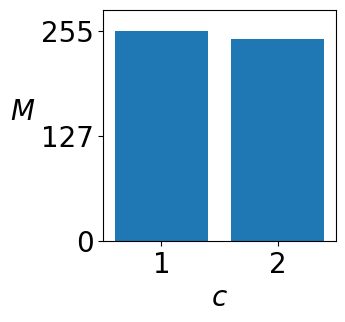

In [27]:
plt.figure(figsize=(3,3))
plt.bar(np.arange(len(new_group_number))+1, new_group_number)
plt.xlim([0.5,len(new_group_number)+0.5])
plt.xticks(list(range(1,len(new_group_number)+1)),fontsize=20)
plt.ylim([0, np.max(new_group_number)*1.1])
plt.yticks([0, int(np.max(new_group_number)/2), int(np.max(new_group_number))],fontsize=20)
plt.xlabel(r"$c$",fontsize=20)
plt.ylabel(r"$M$",fontsize=20,rotation=0,horizontalalignment='right')
plt.show()

In [29]:
classifier = Classifier(similarity_func=topology_comparator, cluster_centers=[models[index] for index in center_indices])
n1 = 51
varepsilons = np.linspace(0.001,2,n1)
v_list = np.zeros(n1)

E_ref = -1.

for i in range(n1):
    hamiltonian = Nonreciprocity1D(E_ref=E_ref)
    hamiltonian.set_parameters(t0=1.0, varepsilon=varepsilons[i])
    _model = NonHermitianTopologicalModel(hamiltonian=hamiltonian, gap_type=gap_type)
    v_list[i] = classifier.classify(_model)

/home/longyang/OSC/ml_topological_classification_non_-hermitian/cases/../topology_model/topology_comparator_utils.py:26: RuntimeWarning: divide by zero encountered in log10
  return np.log10(a0)/epsilon
/home/longyang/anaconda3/lib/python3.9/site-packages/scipy/optimize/_optimize.py:917: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):
/home/longyang/OSC/ml_topological_classification_non_-hermitian/cases/../topology_model/topology_comparator_utils.py:34: RuntimeWarning: divide by zero encountered in log10
  if np.log10(np.abs(v)) < c_val:


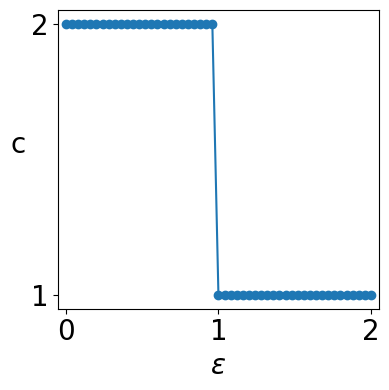

In [30]:
plt.figure(figsize=(4,4))
plt.plot(varepsilons, v_list,'-o')
plt.xticks([0, 1, 2],fontsize=20)
plt.yticks(range(1, len(group_number)+1),fontsize=20)
plt.xlim([-0.05, 2.05])
plt.ylim([1-0.05,len(group_number)+.05])
plt.xlabel(r"$\varepsilon$",fontsize=20)
plt.ylabel(r"c",fontsize=20,rotation=0,horizontalalignment='right')

plt.tight_layout()
plt.show()

# Save data

In [31]:
from tools import save_data, save_data_M

name = "1D_nonreciprocal_real"
save_data(new_center_indices, new_group_number, "fig2_{0}_group_number.h5".format(name))
save_data_M(v_list, "fig2_{0}_phase_diagram.h5".format(name))
print(name)

1D_nonreciprocal_real
